<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Time%2C_Sequences_and_speed_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ✅ STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ STEP 2: Load Excel file (replace path with your actual file path)
import pandas as pd

file_path = '/content/drive/MyDrive/Recruitment/Brøndby 1-1 Nordsjælland.csv'  # <- EDIT THIS
df = pd.read_csv(file_path)

# ✅ STEP 3: Preprocess data
df_sorted = df.sort_values(by=["periodId", "timeMin", "timeSec"]).reset_index(drop=True)
df_sorted["timestamp_sec"] = df_sorted["timeMin"] * 60 + df_sorted["timeSec"]

# Find passes and sequences
passes = df_sorted[df_sorted["typeId"] == 1].copy()
passes["prev_team"] = passes["contestantId"].shift()
passes["prev_time"] = passes["timestamp_sec"].shift()
passes["time_gap"] = passes["timestamp_sec"] - passes["prev_time"]
passes["new_sequence"] = (passes["contestantId"] != passes["prev_team"]) | (passes["time_gap"] > 10)
passes["sequence_id"] = passes["new_sequence"].cumsum()
passes["team_sequence_id"] = passes["contestantId"].astype(str) + "_" + passes["sequence_id"].astype(str)

# Sequence-level metrics
team_sequence_data = passes.groupby("team_sequence_id").agg(
    team_id=("contestantId", "first"),
    sequence_id=("sequence_id", "first"),
    start_x=("x", "first"),
    end_x=("x", "last"),
    start_y=("y", "first"),
    end_y=("y", "last"),
    start_time=("timestamp_sec", "first"),
    end_time=("timestamp_sec", "last"),
    num_passes=("x", "count")
)

# Distance and speed calculations
team_sequence_data["duration"] = team_sequence_data["end_time"] - team_sequence_data["start_time"]
team_sequence_data = team_sequence_data[team_sequence_data["duration"] > 0]
team_sequence_data["distance_upfield"] = team_sequence_data["end_x"] - team_sequence_data["start_x"]
team_sequence_data["lateral_distance"] = abs(team_sequence_data["end_y"] - team_sequence_data["start_y"])
team_sequence_data["total_distance"] = ((team_sequence_data["end_x"] - team_sequence_data["start_x"])**2 +
                                        (team_sequence_data["end_y"] - team_sequence_data["start_y"])**2) ** 0.5
team_sequence_data["direct_speed_mps"] = team_sequence_data["distance_upfield"] / team_sequence_data["duration"]
team_sequence_data["total_speed_mps"] = team_sequence_data["total_distance"] / team_sequence_data["duration"]

# Aggregate by team
team_metrics = team_sequence_data.groupby("team_id").agg(
    sequences=("sequence_id", "nunique"),
    avg_passes_per_sequence=("num_passes", "mean"),
    avg_direct_speed_mps=("direct_speed_mps", "mean"),
    avg_total_speed_mps=("total_speed_mps", "mean"),
    avg_upfield_progress=("distance_upfield", "mean"),
    avg_lateral_movement=("lateral_distance", "mean"),
    avg_sequence_duration=("duration", "mean")
).reset_index()

# Calculate effective match time per team
df_sorted["timestamp_sec_shifted"] = df_sorted["timestamp_sec"].shift()
df_sorted["time_diff"] = df_sorted["timestamp_sec"] - df_sorted["timestamp_sec_shifted"]
in_play = df_sorted[(df_sorted["time_diff"] > 0) & (df_sorted["time_diff"] <= 15)]
in_play["team_id"] = df_sorted["contestantId"].fillna(method='ffill')

team_time = in_play.groupby("team_id")["time_diff"].sum().reset_index()
team_time.columns = ["team_id", "effective_time_sec"]
team_time["effective_minutes"] = team_time["effective_time_sec"] / 60

# Merge time with metrics
team_metrics = team_metrics.merge(team_time, on="team_id", how="left")
team_metrics["possessions_per_minute"] = team_metrics["sequences"] / team_metrics["effective_minutes"]
team_metrics["passes_per_minute"] = (team_metrics["avg_passes_per_sequence"] * team_metrics["sequences"]) / team_metrics["effective_minutes"]

# ✅ Print final metrics
print("Team Metrics:")
print(team_metrics)

# ✅ Total Match Metrics
total_metrics = {
    "total_sequences": team_metrics["sequences"].sum(),
    "total_passes": (team_metrics["avg_passes_per_sequence"] * team_metrics["sequences"]).sum(),
    "total_effective_minutes": team_metrics["effective_minutes"].sum(),
    "avg_direct_speed_mps": team_metrics["avg_direct_speed_mps"].mean(),
    "avg_total_speed_mps": team_metrics["avg_total_speed_mps"].mean(),
    "avg_upfield_progress": team_metrics["avg_upfield_progress"].mean(),
    "avg_lateral_movement": team_metrics["avg_lateral_movement"].mean(),
    "avg_sequence_duration": team_metrics["avg_sequence_duration"].mean(),
    "avg_possessions_per_minute": team_metrics["possessions_per_minute"].mean(),
    "avg_passes_per_minute": team_metrics["passes_per_minute"].mean()
}

print("\nTotal Match Metrics:")
print(pd.DataFrame([total_metrics]))


Mounted at /content/drive
Team Metrics:
                     team_id  sequences  avg_passes_per_sequence  \
0  77tfx9me4aaqhzv78bmgsy9bg         93                 8.677419   
1  9qsmopgutr7ut5g6workk8w4i         73                 5.410959   

   avg_direct_speed_mps  avg_total_speed_mps  avg_upfield_progress  \
0              1.482780             4.369941             15.851613   
1              2.208111             5.229560             16.712329   

   avg_lateral_movement  avg_sequence_duration  effective_time_sec  \
0             32.089247              21.591398              2622.0   
1             27.827397              13.863014              1721.0   

   effective_minutes  possessions_per_minute  passes_per_minute  
0          43.700000                2.128146          18.466819  
1          28.683333                2.545032          13.771063  

Total Match Metrics:
   total_sequences  total_passes  total_effective_minutes  \
0              166        1202.0                72.3

<ipython-input-1-308f55c7d4fd>:62: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  in_play["team_id"] = df_sorted["contestantId"].fillna(method='ffill')
<ipython-input-1-308f55c7d4fd>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_play["team_id"] = df_sorted["contestantId"].fillna(method='ffill')


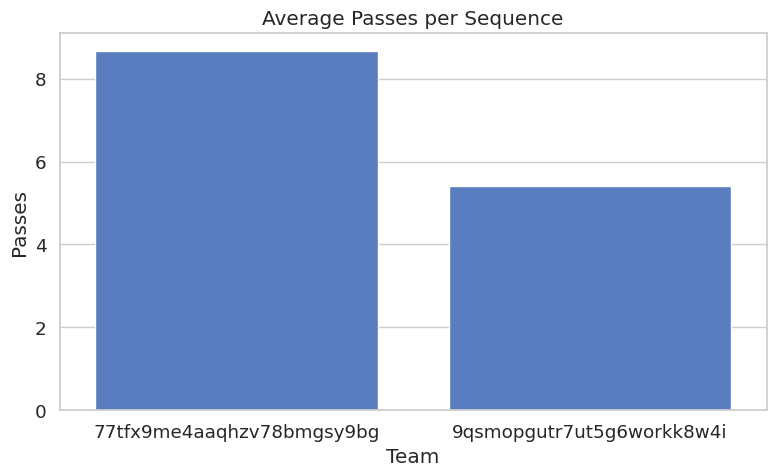

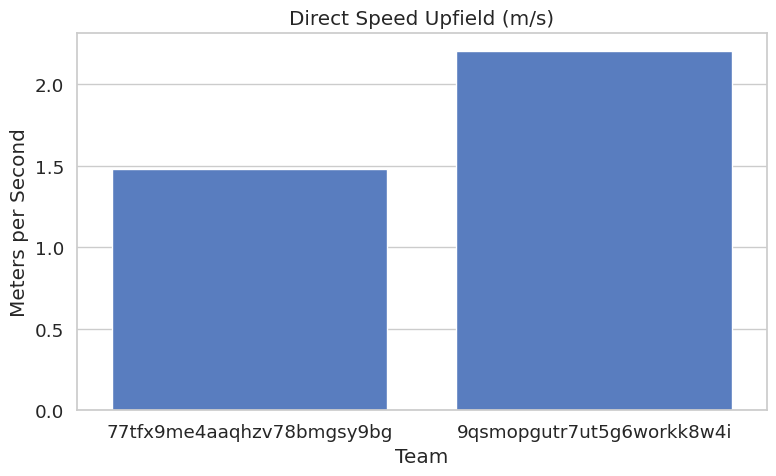

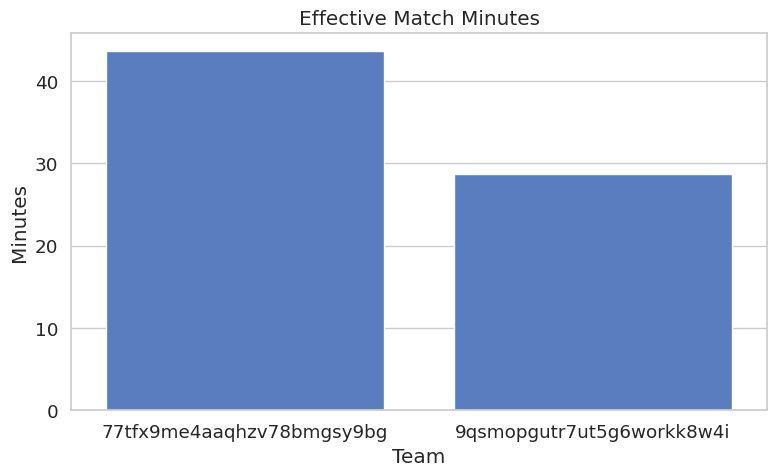

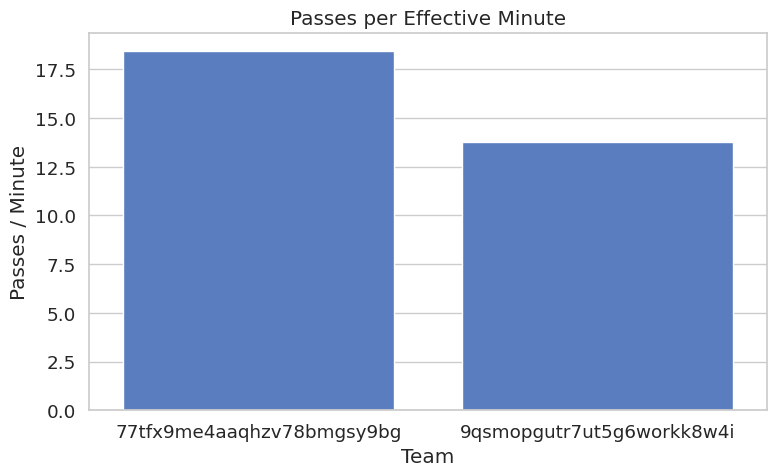

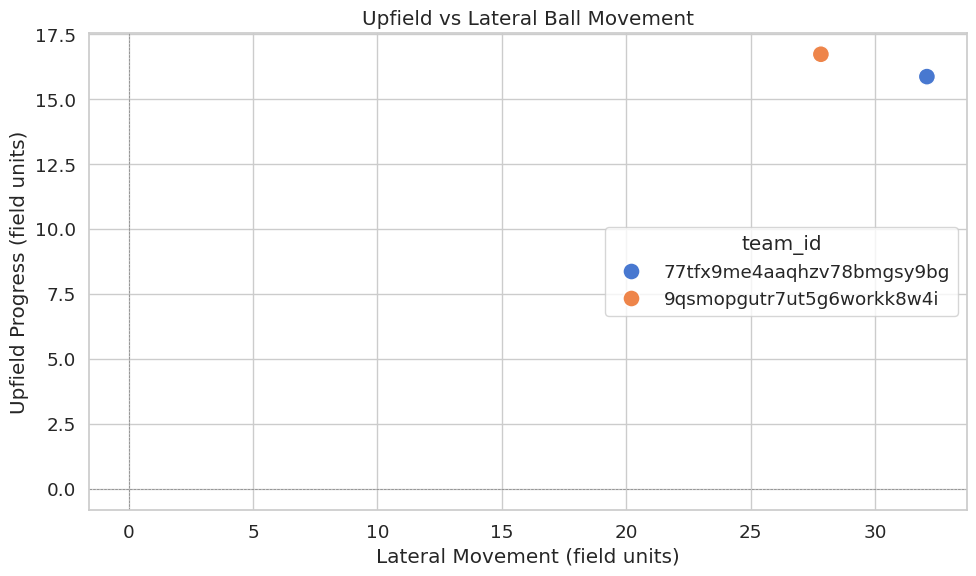

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set aesthetic style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# ---------- 1. Passes per Sequence ----------
plt.figure(figsize=(8, 5))
sns.barplot(data=team_metrics, x="team_id", y="avg_passes_per_sequence")
plt.title("Average Passes per Sequence")
plt.ylabel("Passes")
plt.xlabel("Team")
plt.tight_layout()
plt.show()

# ---------- 2. Direct Speed (m/s) ----------
plt.figure(figsize=(8, 5))
sns.barplot(data=team_metrics, x="team_id", y="avg_direct_speed_mps")
plt.title("Direct Speed Upfield (m/s)")
plt.ylabel("Meters per Second")
plt.xlabel("Team")
plt.tight_layout()
plt.show()

# ---------- 3. Effective Match Time ----------
plt.figure(figsize=(8, 5))
sns.barplot(data=team_metrics, x="team_id", y="effective_minutes")
plt.title("Effective Match Minutes")
plt.ylabel("Minutes")
plt.xlabel("Team")
plt.tight_layout()
plt.show()

# ---------- 4. Passes per Minute ----------
plt.figure(figsize=(8, 5))
sns.barplot(data=team_metrics, x="team_id", y="passes_per_minute")
plt.title("Passes per Effective Minute")
plt.ylabel("Passes / Minute")
plt.xlabel("Team")
plt.tight_layout()
plt.show()

# ---------- 5. Upfield Progress vs Lateral Movement ----------
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=team_metrics,
    x="avg_lateral_movement",
    y="avg_upfield_progress",
    hue="team_id",
    s=150
)
plt.title("Upfield vs Lateral Ball Movement")
plt.xlabel("Lateral Movement (field units)")
plt.ylabel("Upfield Progress (field units)")
plt.axhline(0, color="gray", linestyle="--", linewidth=0.5)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [3]:
# Install openpyxl if not available
!pip install openpyxl --quiet

# Create a Pandas Excel writer using XlsxWriter
from pandas import ExcelWriter
import os

# Define save path in Google Drive
save_path = '/content/drive/MyDrive/match_metrics_output.xlsx'  # Change path/filename as needed

# Convert total_metrics dict to DataFrame
total_metrics_df = pd.DataFrame([total_metrics])

# Save both team and total metrics
with pd.ExcelWriter(save_path, engine='openpyxl') as writer:
    team_metrics.to_excel(writer, sheet_name='Team Metrics', index=False)
    total_metrics_df.to_excel(writer, sheet_name='Total Metrics', index=False)

print(f"✅ Excel file saved to: {save_path}")


✅ Excel file saved to: /content/drive/MyDrive/match_metrics_output.xlsx
